![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)

In [39]:
import tushare as ts
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from tqdm.notebook import tqdm_notebook


from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
%matplotlib inline

#设置完整显示数据
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 
              500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)

pro = ts.pro_api('xxxxxxxxxxxxxxx')
ts.set_token('xxxxxxxxxxxxxxx')

#交易日期
trade_date = '20211207'

In [66]:
#【光伏组件】行业（同花顺-)中包含的14只股票：
tickers = ['爱旭股份', '晶澳科技', '协鑫集成', '中环股份', '东方日升', '中来股份', '亿晶光电', '天合光能', '向日葵', '隆基股份', '通威股份', '正泰电器', '航天机电', '拓日新能']
#tickers = ['中环股份', '隆基股份', '通威股份']

In [67]:
stock_basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,list_date')

if tickers[0].isnumeric():
    stock_list = stock_basic[stock_basic['symbol'].isin(tickers)]
else:
    stock_list = stock_basic[stock_basic['name'].isin(tickers)]

In [68]:
daily_basic = pro.daily_basic(ts_code='', trade_date=trade_date, fields='ts_code,trade_date,pe,pe_ttm,pb,total_mv,circ_mv')
daily_basic['total_mv'] = daily_basic['total_mv'].div(10000)
daily_basic['circ_mv'] = daily_basic['circ_mv'].div(10000)
stock_list = stock_list.merge(daily_basic, on=['ts_code'])

# 一、股票间相关性

In [83]:
## 其实这属于可有可无的分析，没有需要的可以忽略

In [69]:
_names = stock_list['name']
all_data ={}

#遍历list里面的股票，可以写入多个股票
for name,ts_code in zip(stock_list['name'],stock_list['ts_code']):
    #获取各股票某时段的价格
    all_data[name] = ts.pro_bar(ts_code=ts_code, adj='qfq', start_date='20200521', end_date=trade_date)
#用for循环遍历股票价格并转换为dataframe的形式
p_data = pd.DataFrame({tic: data['close']
                    for tic, data in all_data.items()})
p_data['平均值']= p_data.mean(axis=1)
#计算股票价格每日变化
returns = p_data.pct_change()[1:]

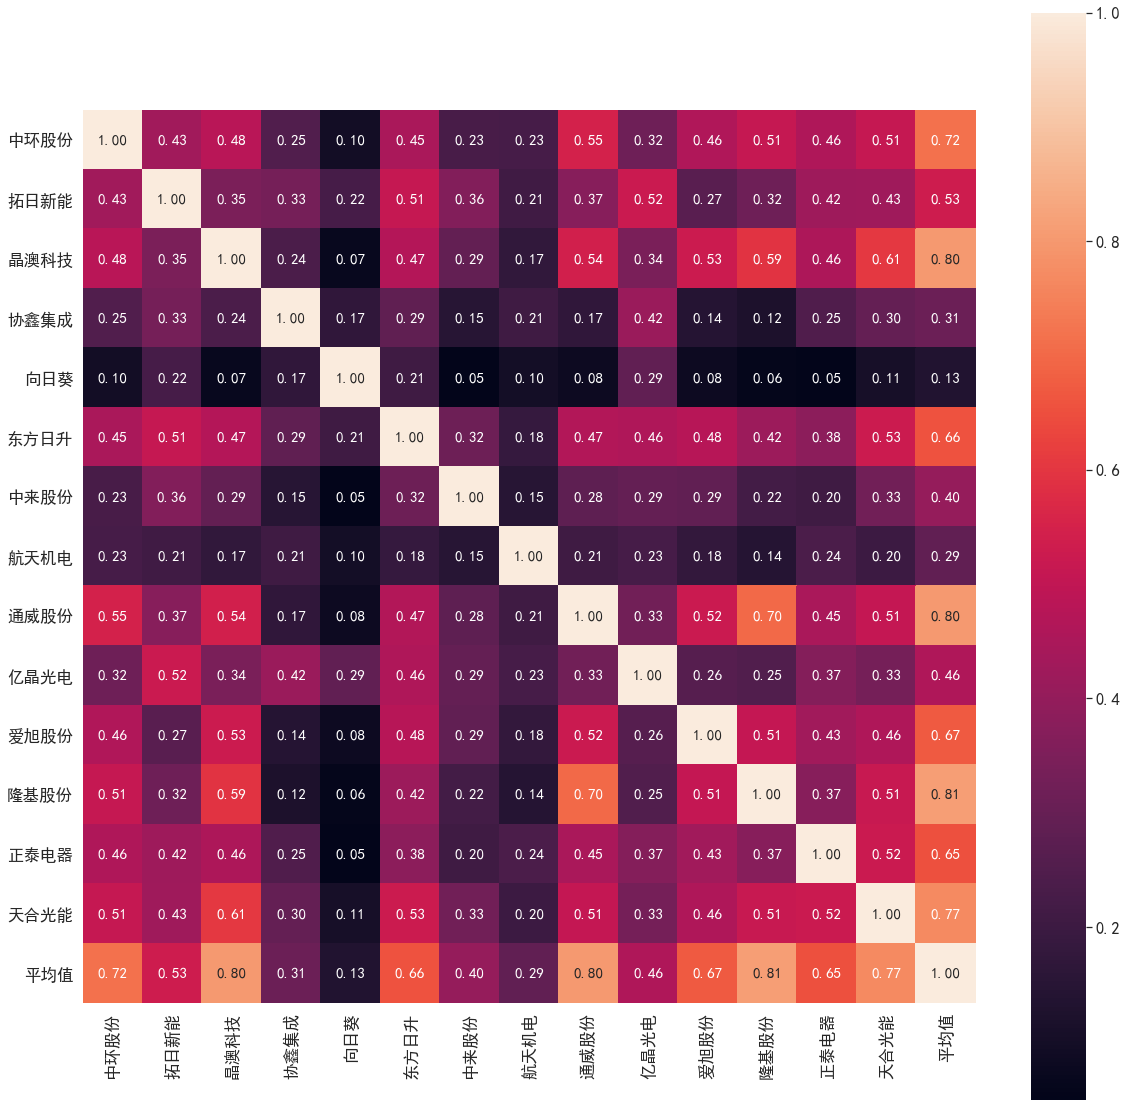

In [70]:
fig, ax = plt.subplots(figsize=(20,20)) 
cm = np.corrcoef(returns.values.T)
sns.set(font_scale=1.5,font=myfont.get_name())
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']}) 

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=returns.columns,
                 xticklabels=returns.columns,
                 ax=ax)


# 二、股东人数增减与股票市值的关系

- 因为需要解决数据接口数据不完整的问题，下面分情况使用到了两个数据接口，一个是akshare，一个是tushare
- 主要是利用了linregress这个函数来分析持股人数变化和涨跌幅的相关性，主要用到了R_Value 和R_Value的平方，不懂的可以百度
-  关于“统计数”的作用，样本samples的大小在统计学中是有比较严格的规定的，当然数据是越多越好，如果不够多的去

## （1）Akshare

In [79]:
def stock_zh_a_gdhs_detail_em(row, retry_count=3, pause=15):
    for _ in range(retry_count):
        try:
            df = ak.stock_zh_a_gdhs_detail_em(symbol=row['symbol'])
            df = df.drop_duplicates()
        except:
            time.sleep(pause)
        else:
            return df
        

In [80]:
ak_result_list = []
for index, t_row in tqdm_notebook(stock_list.iterrows(), total=stock_list.shape[0]):

    data = stock_zh_a_gdhs_detail_em(t_row)

    slope, intercept, r_value, p_value, std_err = linregress(data['股东户数-增减比例'], data['区间涨跌幅'])

    result_dict = {}
    result_dict['ts_code'] = t_row['ts_code']
    result_dict['代码 '] = t_row['symbol']
    result_dict['名称'] = t_row['name']
    result_dict['上市日'] = t_row['list_date']
    result_dict['slope'] = slope
    result_dict['intercept'] = intercept
    result_dict['r_value'] = r_value
    result_dict['r_sqrd'] = r_value*r_value
    result_dict['p_value'] = p_value
    result_dict['std_err'] = std_err
    result_dict['统计数'] = len(data.index)

    ak_result_list.append(result_dict)
ak_result_df = pd.DataFrame(ak_result_list)
ak_result_df

  0%|          | 0/14 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]
                                                                                                                       
100%|██████████████████████████████████

,ts_code,代码,名称,上市日,slope,intercept,r_value,r_sqrd,p_value,std_err,统计数
0,002129.SZ,002129,中环股份,20070420,0.03,5.80,0.04,0.00,0.80,0.13,54
1,002218.SZ,002218,拓日新能,20080228,0.20,1.06,0.11,0.01,0.20,0.16,139
2,002459.SZ,002459,晶澳科技,20100810,-0.09,9.20,-0.08,0.01,0.62,0.17,43
3,002506.SZ,002506,协鑫集成,20101118,1.63,-1.42,0.81,0.65,0.00,0.19,40
4,300111.SZ,300111,向日葵,20100827,0.06,1.23,0.15,0.02,0.33,0.06,42
5,300118.SZ,300118,东方日升,20100902,-0.10,6.31,-0.05,0.00,0.76,0.32,48
6,300393.SZ,300393,中来股份,20140912,NaN,NaN,NaN,NaN,NaN,NaN,34
7,600151.SH,600151,航天机电,19980605,-0.04,4.15,-0.02,0.00,0.92,0.38,38
8,600438.SH,600438,通威股份,20040302,-0.12,11.14,-0.17,0.03,0.30,0.11,39
9,600537.SH,600537,亿晶光电,20030123,0.86,1.93,0.47,0.22,0.00,0.26,40


## （2）Tushare

In [73]:
def tushare_stock_zh_a_gdhs_detail_em(row, retry_count=3, pause=15):
    for _ in range(retry_count):
        try:
            df = pro.stk_holdernumber(ts_code=row['ts_code'])
            p_data = ts.pro_bar(ts_code=row['ts_code'], adj='qfq')
        except:
            time.sleep(pause)
        else:
            df.sort_values(by='ann_date', ascending=True,inplace=True)
            df['holder_num_chg'] = df['holder_num'].pct_change()*100

            p_data = p_data[['trade_date','close']]
            
            result = df.merge(p_data,left_on=['ann_date'], right_on=['trade_date'])
            result['pct_chg'] = result['close'].pct_change()*100
            result = result.dropna()
            
            return result

In [74]:
ts_result_list = []
for index, t_row in tqdm_notebook(stock_list.iterrows(), total=stock_list.shape[0]):
    try:
        data = tushare_stock_zh_a_gdhs_detail_em(t_row)

    except Exception as e:
        print(e)
        pass
    else:
        try:
            slope, intercept, r_value, p_value, std_err = linregress(data['holder_num_chg'], data['pct_chg'])
        except:
            slope = intercept =  r_value = p_value = std_err = 0

        result_dict = {}
        
        result_dict['ts_code'] = t_row['ts_code']
        result_dict['代码'] = t_row['symbol']
        result_dict['名称'] = t_row['name']
        result_dict['上市日'] = t_row['list_date']
        result_dict['slope'] = slope
        result_dict['intercept'] = intercept
        result_dict['r_value'] = r_value
        result_dict['r_sqrd'] = r_value*r_value
        result_dict['p_value'] = p_value
        result_dict['std_err'] = std_err
        result_dict['统计数'] = len(data.index)
        
        
        ts_result_list.append(result_dict)
ts_result_df = pd.DataFrame(ts_result_list)
ts_result_df

  0%|          | 0/14 [00:00<?, ?it/s]

,ts_code,代码,名称,上市日,slope,intercept,r_value,r_sqrd,p_value,std_err,统计数
0,002129.SZ,002129,中环股份,20070420,-0.18,11.28,-0.14,0.02,0.34,0.18,46
1,002218.SZ,002218,拓日新能,20080228,0.12,0.96,0.09,0.01,0.28,0.11,143
2,002459.SZ,002459,晶澳科技,20100810,-0.41,8.08,-0.32,0.10,0.06,0.21,36
3,002506.SZ,002506,协鑫集成,20101118,2.38,-6.44,0.55,0.30,0.02,0.94,17
4,300111.SZ,300111,向日葵,20100827,-0.05,-0.59,-0.10,0.01,0.53,0.08,43
5,300118.SZ,300118,东方日升,20100902,0.17,2.45,0.07,0.01,0.60,0.33,55
6,300393.SZ,300393,中来股份,20140912,0.27,3.29,0.26,0.07,0.17,0.19,30
7,600151.SH,600151,航天机电,19980605,-0.31,6.16,-0.17,0.03,0.15,0.22,71
8,600438.SH,600438,通威股份,20040302,-0.06,12.21,-0.12,0.01,0.36,0.06,60
9,600537.SH,600537,亿晶光电,20030123,-0.52,10.44,-0.19,0.04,0.13,0.34,64


![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)